In [1]:
from dataset_making import *
from functions import *
import time

## FINAL TEST

In [2]:
# ORB FEATURE SETUP
orb = cv2.ORB_create(nfeatures=300, WTA_K=2, scoreType=0)

index_params = dict(algorithm=6,
                    table_number=6,
                    key_size=12,
                    multi_probe_level=2)
search_params = {}
matcher = cv2.FlannBasedMatcher(index_params, search_params)

In [3]:
# MASK_RNN SETUP
model = get_instance_segmentation_model(num_classes=2)
model.load_state_dict(torch.load('learned_weights/gate_det_maskrnn.pt'))
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [4]:
# LOAD AND SORT IMAGES FILENAMES INTO LISTS
image_dir = 'WashingtonOBRace'

img_filenames = glob.glob(os.path.join(image_dir, 'img_[0-9]*.png'))
img_filenames = sorted(img_filenames, key=lambda x:int(x[21:-4]))
print(f'Found {len(img_filenames)} image files in the directory "{image_dir}"')

mask_filenames = glob.glob(os.path.join(image_dir, 'mask_*.png'))
mask_filenames = sorted(mask_filenames, key=lambda x:int(x[22:-4]))
print(f'Found {len(mask_filenames)} mask files in the directory "{image_dir}"')

# READ AND STORE IMAGES AND MASKS INTO LISTS
imgs = [cv2.imread(filename, flags=cv2.IMREAD_COLOR) \
                                for filename in img_filenames]
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs]
print('loaded %d images' % len(imgs))

masks = [cv2.imread(filename, flags=cv2.IMREAD_GRAYSCALE) \
                                 for filename in mask_filenames]
print('loaded %d masks' % len(masks))

Found 308 image files in the directory "WashingtonOBRace"
Found 308 mask files in the directory "WashingtonOBRace"
loaded 308 images
loaded 308 masks


In [5]:
pred_masks = []
prev_mask = None
queryKps, queryDes = None, None

start_time = time.time()

break_idxs = np.array([58, 148, 246, 253])

for idx in range(len(imgs)):
    trainImg = imgs[idx]
    trainKp = orb.detect(trainImg,None)
    trainKps, trainDes = orb.compute(trainImg, trainKp)
    
    pred_mask = None
    if idx % 5 == 0 or idx in break_idxs:
        img_file = [img_filenames[idx]]
        mask_file = [mask_filenames[idx]]
        dataset_test_0 = GateSegDataset(img_file, mask_file, \
                                        transforms=get_transform(train=False))
        img, _ = dataset_test_0[0]
        with torch.no_grad():
            prediction = model([img.to(device)])
        pred_mask = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
        pred_mask = pred_mask / np.max(pred_mask)
        # SET A THRESHOLD OF 0.5
        pred_mask[pred_mask >= 0.5] = 1
        pred_mask[pred_mask < 0.5] = 0
    else:
        prev_mask = pred_masks[-1]
        matches = matcher.knnMatch(queryDes, trainDes, k=8)
        good_matches = find_good_matches(matches, queryKps, trainKps)
        pred_mask = perspective_transform(good_matches, queryKps, trainKps, prev_mask)
        
    pred_masks.append(pred_mask)
    queryKps, queryDes = trainKps, trainDes
    
end_time = time.time()
print("In {0} seconds.".format(end_time - start_time))
print("Average processing time: {0}.".format((end_time - start_time)/len(imgs)))

In 16.719757795333862 seconds.
Average processing time: 0.054284927906928127.


308


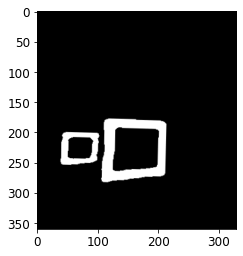

In [6]:
print(len(pred_masks))
plt.imshow(pred_masks[6], 'gray')
plt.show()

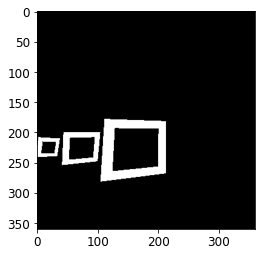

In [7]:
plt.imshow(masks[6], 'gray')
plt.show()

In [14]:
# CALCULATE AVERAGE ACCURACY
# ATTENTION: SOME MASKS SHAPE LIKE 360*345, 360*330. NOT 360*360

accs = []
precisions = []
recalls = []
f_scores = []
for idx in range(len(masks)):
    mask = masks[idx]
    mask[mask > 0] = 1
    pred_mask = pred_masks[idx].astype(np.uint8)
    h, w = min(mask.shape[0], pred_mask.shape[0]), min(mask.shape[1], pred_mask.shape[1])
    n = h * w
    mask = mask[:h, :w].flatten()
    pred_mask = pred_mask[:h, :w].flatten()

    # ACCURACY
    correct = np.sum((mask == pred_mask) * 1)
    accuracy = correct / n
    
    # PRECISION, RECALL AND F-SCORE
    positives_ind = np.nonzero(mask)
    true_postives = np.sum((pred_mask[positives_ind] == 1) * 1)
    pred_positives = np.sum(pred_mask)
    gt_positives = np.sum(mask)
    precision = true_postives / pred_positives
    recall = true_postives / gt_positives
    f_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    accs.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f_scores.append(f_score)

In [15]:
print(accs[:10])

[0.9936574074074074, 0.9822067901234568, 0.9771913580246914, 0.9746859903381643, 0.9711276948590382, 0.9930892255892256, 0.9841077441077442, 0.9762205387205387, 0.9672558922558923, 0.9657239057239058]


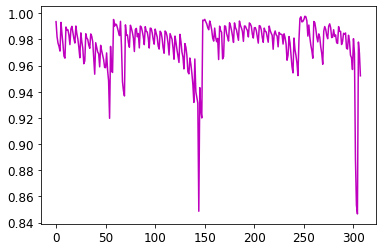

In [16]:
plt.figure()
plt.plot(range(len(masks)), accs, color = 'm')

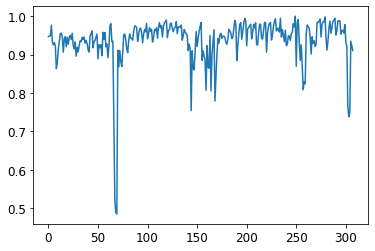

In [17]:
plt.figure()
plt.plot(range(len(masks)), precisions)

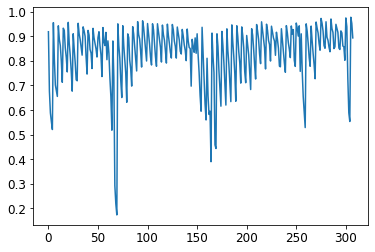

In [18]:
plt.figure()
plt.plot(range(len(masks)), recalls)

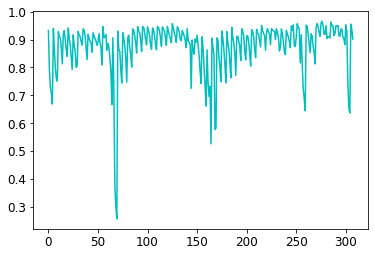

In [19]:
plt.figure()
plt.plot(range(len(masks)), f_scores, 'c')

In [22]:
avg_accuracy = np.mean(accs)
avg_f_score = np.mean(f_scores)
print(avg_accuracy, avg_f_score)

0.976713640084676 0.8747365086006416


In [61]:
# idx = np.argmin(precisions)
# idx = np.argmin(recalls)

## PERFORMANCE VS. COMPLEXITY

In [44]:
avg_accuracies = []
avg_f_scores = []
avg_runtimes = []

features = [150, 200, 250, 300, 350, 400, 450, 500]
intervals = [1, 3, 5, 7, 9, 11, 13, 15]

In [45]:
for i in range(8):
#     # SWITCH
#     nfeatures = features[i]
#     interval = 5
    
    # SWITCH
    nfeatures = 300
    interval = intervals[i]
    
    orb = cv2.ORB_create(nfeatures=nfeatures, WTA_K=2, scoreType=0)

    index_params = dict(algorithm=6,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=2)
    search_params = {}
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    pred_masks = []
    prev_mask = None
    queryKps, queryDes = None, None

    start_time = time.time()

    break_idxs = np.array([58, 148, 246, 253])

    for idx in range(len(imgs)):
        trainImg = imgs[idx]
        trainKp = orb.detect(trainImg,None)
        trainKps, trainDes = orb.compute(trainImg, trainKp)

        pred_mask = None
        if idx % interval == 0 or idx in break_idxs:
            img_file = [img_filenames[idx]]
            mask_file = [mask_filenames[idx]]
            dataset_test_0 = GateSegDataset(img_file, mask_file, \
                                            transforms=get_transform(train=False))
            img, _ = dataset_test_0[0]
            with torch.no_grad():
                prediction = model([img.to(device)])
            pred_mask = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
            pred_mask = pred_mask / np.max(pred_mask)
            # SET A THRESHOLD OF 0.5
            pred_mask[pred_mask >= 0.5] = 1
            pred_mask[pred_mask < 0.5] = 0
        else:
            prev_mask = pred_masks[-1]
            matches = matcher.knnMatch(queryDes, trainDes, k=8)
            good_matches = find_good_matches(matches, queryKps, trainKps)
            pred_mask = perspective_transform(good_matches, queryKps, trainKps, prev_mask)

        pred_masks.append(pred_mask)
        queryKps, queryDes = trainKps, trainDes

    end_time = time.time()
#     print("In {0} seconds.".format(end_time - start_time))
#     print("Average processing time: {0}.".format((end_time - start_time)/len(imgs)))

    accs = []
    precisions = []
    recalls = []
    f_scores = []
    for idx in range(len(masks)):
        mask = masks[idx]
        mask[mask > 0] = 1
        pred_mask = pred_masks[idx].astype(np.uint8)
        h, w = min(mask.shape[0], pred_mask.shape[0]), min(mask.shape[1], pred_mask.shape[1])
        n = h * w
        mask = mask[:h, :w].flatten()
        pred_mask = pred_mask[:h, :w].flatten()

        # ACCURACY
        correct = np.sum((mask == pred_mask) * 1)
        accuracy = correct / n

        # PRECISION, RECALL AND F-SCORE
        positives_ind = np.nonzero(mask)
        true_postives = np.sum((pred_mask[positives_ind] == 1) * 1)
        pred_positives = np.sum(pred_mask)
        gt_positives = np.sum(mask)
        precision = true_postives / pred_positives
        recall = true_postives / gt_positives
        f_score = 2 * (precision * recall) / (precision + recall + 1e-6)

        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f_scores.append(f_score)

    avg_accuracy = np.mean(accs)
    avg_f_score = np.mean(f_scores)
    
    avg_runtimes.append((end_time - start_time)/len(imgs))
    avg_accuracies.append(avg_accuracy)
    avg_f_scores.append(avg_f_score)

<ipython-input-45-6a711bdee2ed>:81: RuntimeWarning: invalid value encountered in true_divide
  precision = true_postives / pred_positives


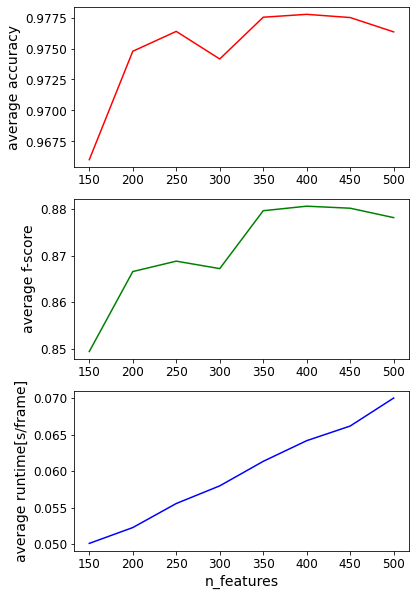

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(6,10))
axes[0].plot(features, avg_accuracies, 'r')
axes[0].set_ylabel('average accuracy')
axes[1].plot(features, avg_f_scores, 'g')
axes[1].set_ylabel('average f-score')
axes[2].plot(features, avg_runtimes, 'b')
axes[2].set_ylabel('average runtime[s/frame]')
plt.xlabel('n_features')

plt.show()

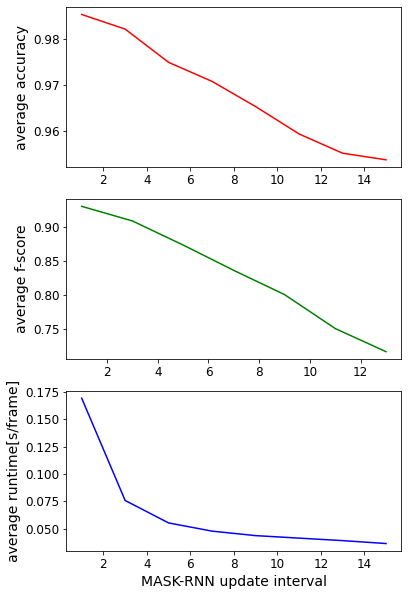

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(6,10))
axes[0].plot(intervals, avg_accuracies, 'r')
axes[0].set_ylabel('average accuracy')
axes[1].plot(intervals, avg_f_scores, 'g')
axes[1].set_ylabel('average f-score')
axes[2].plot(intervals, avg_runtimes, 'b')
axes[2].set_ylabel('average runtime[s/frame]')
plt.xlabel('MASK-RNN update interval')

plt.show()